In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import copy
import cv2
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive
# !unzip Data.zip # If first time

# drive.flush_and_unmount()

/content/drive/MyDrive


In [ ]:
df = pd.read_csv("Data/features_30_sec.csv")
df = df[['filename','label']]

In [ ]:
class_name = {}
n = 0
for i in set(df['label']):
    class_name[i] = n
    n+=1
num_classes = n

In [ ]:
df['label'] = df['label'].map(class_name)

In [ ]:
df

,filename,label
0,blues.00000.wav,5
1,blues.00001.wav,5
2,blues.00002.wav,5
3,blues.00003.wav,5
4,blues.00004.wav,5
...,...,...
994,rock.00095.wav,4
995,rock.00096.wav,4
996,rock.00097.wav,4
997,rock.00098.wav,4


In [ ]:
new_df = pd.DataFrame(columns=["filename", "label"], index=[i for i in range(3*len(df))])

In [ ]:
new_df

,filename,label
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
2992,NaN,NaN
2993,NaN,NaN
2994,NaN,NaN
2995,NaN,NaN


In [ ]:
for i in range(len(df)):
    temp = df['filename'][i].split(".")
    genre = temp[0]
    idx = temp[1]
    # df['filename'][i] = "Data/images_original/" + temp[0] + "/" + temp[0] + temp[1] + ".png"

    # Read image then split it into 3 
    # pic = cv2.imread(df['filename'][i])
    # cropped_img_1 = pic[:, :113]
    # cropped_img_2 = pic[:, 113:226]
    # cropped_img_3 = pic[:, 226:]

    # _, axarr = plt.subplots(1,3) 

    # axarr[0].imshow(cropped_img_1)
    # axarr[1].imshow(cropped_img_2)
    # axarr[2].imshow(cropped_img_3)

    # print(genre, idx)
    # print(genre, str(1) + idx[1:])
    # print(genre, str(2) + idx[1:])

    new_df.iloc[3*i] = ["Data/images_augmented/" + genre + "/" + genre + idx + ".png", df['label'][i]]
    new_df.iloc[3*i+1] = ["Data/images_augmented/" + genre + "/" + genre + str(1) + idx[1:] + ".png", df['label'][i]]
    new_df.iloc[3*i+2] = ["Data/images_augmented/" + genre + "/" + genre + str(2) + idx[1:] + ".png", df['label'][i]]

    # Save and write split images 
    # cv2.imwrite("Data/images_augmented/" + genre + "/" + genre + idx + ".png", cropped_img_1)
    # cv2.imwrite("Data/images_augmented/" + genre + "/" + genre + str(1) + idx[1:] + ".png", cropped_img_2)
    # cv2.imwrite("Data/images_augmented/" + genre + "/" + genre + str(2) + idx[1:] + ".png", cropped_img_3)

In [ ]:
new_df

,filename,label
0,Data/images_augmented/blues/blues00000.png,5
1,Data/images_augmented/blues/blues10000.png,5
2,Data/images_augmented/blues/blues20000.png,5
3,Data/images_augmented/blues/blues00001.png,5
4,Data/images_augmented/blues/blues10001.png,5
...,...,...
2992,Data/images_augmented/rock/rock10098.png,4
2993,Data/images_augmented/rock/rock20098.png,4
2994,Data/images_augmented/rock/rock00099.png,4
2995,Data/images_augmented/rock/rock10099.png,4


In [ ]:
# train, test = train_test_split(df, test_size=0.20, random_state=42, stratify = df['label'])
# test, val = train_test_split(test, test_size=0.50, random_state=42, stratify = test['label'])

In [ ]:
train, test = train_test_split(new_df, test_size=0.20, random_state=42, stratify = new_df['label'])
test, val = train_test_split(test, test_size=0.50, random_state=42, stratify = test['label'])

In [ ]:
dataset_sizes = {'train': len(train), 'test': len(test), 'val': len(val)}
print(dataset_sizes)

{'train': 2397, 'test': 300, 'val': 300}


In [ ]:
class GenreDataset(Dataset):
    """Genre dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = cv2.imread(img_name,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        details = self.csv.iloc[idx, 1:]
        sample = {'image': image, 'label': details[0]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
class PreProcessing(object):

    def __init__(self):
        pass

    def __call__(self, sample):
        image, turtle_id = sample['image'], sample['label']
        h, w = image.shape[:2]
        
        ### ADD PREPROCESSING CODE HERE
        
        return [torch.Tensor(image.transpose(2,0,1)), turtle_id]

In [ ]:
train_transformed_dataset = GenreDataset(csv_file=train,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
test_transformed_dataset = GenreDataset(csv_file=test,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
val_transformed_dataset = GenreDataset(csv_file=val,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))

In [ ]:
dataloaders = {'train' : DataLoader(train_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0),
              'test' : DataLoader(test_transformed_dataset, batch_size=8,
                        shuffle=True, num_workers=0),
              'val' : DataLoader(val_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0)}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     losses = {'train':[], 'val':[]}
#     accuracies = {'train':[], 'val':[]}
#     every_n_epoch = 5

#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 # inputs = inputs.type(torch.DoubleTensor)
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs.float())
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))
            
#             if epoch%every_n_epoch == 0:
#               losses[phase] += [epoch_loss]
#               accuracies[phase] += [epoch_acc.cpu().detach().numpy()]

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, losses, accuracies

In [ ]:
def train_rnn(model, criterion, optimizer, scheduler, input_size, seq_length, num_epochs=25):
    losses = {'train':[], 'val':[]}
    accuracies = {'train':[], 'val':[]}

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.type(torch.DoubleTensor)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # Reshape inputs to (batch_size, seq_length, input_size)
                    new_inputs = inputs.reshape(-1, seq_length, input_size).to(device)
                    labels = labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    outputs = model(new_inputs, phase == "train")

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc.cpu().detach().numpy())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

### Need to define our model below

In [ ]:
# # image shape is (221, 339, 1)

# class CNN(nn.Module):
#   def __init__(self):
#     super().__init__()

#     self._convblocks = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d((3,3), (2,2)),

#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d((2,3), (2,2)),

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d((5,6), (5,6)),

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d((6,6), (5,4))
#         )
#     self._classifier = nn.Sequential(nn.Linear(in_features=1536, out_features=1024),
#                                       nn.ReLU(),
#                                       nn.Dropout(),
#                                       nn.Linear(in_features=1024, out_features=10))
#     # self._prob = nn.Softmax(dim=1)
#     self.apply(self._init_weights)

#   def forward(self, x):
#       x = self._convblocks(x)
#       x = x.view(x.size(0), -1)
#       # out = self._classifier(x)
#       # score = self._prob(out)
#       score = self._classifier(x)
#       return score

#   def _init_weights(self, layer) -> None:
#       if isinstance(layer, nn.Linear):
#         nn.init.xavier_uniform_(layer.weight)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # batch_first = True -> (batch, seq_dim, input_features)
        # self.rnn = nn.RNN(input_size, hidden_dim, num_layers, batch_first=True)
        # self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.gru = nn.GRU(input_size, hidden_dim, num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        
    def forward(self, x, trn):
        
        h_init = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        # c_init = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        # out, _ = self.rnn(x, h_init)
        # out, (_,_) = self.lstm(x, (h_init,c_init))
        out, _ = self.gru(x, h_init)
        out = self.fc1(out[:,-1,:])
        out = torch.sigmoid(out)
        out = nn.functional.dropout(out, training=trn)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        out = nn.functional.dropout(out, training=trn)
        out = self.fc3(out)

        # Place only the output from last step into the FC layer
        # out -> (batch_size, hidden_size)
        return out

In [ ]:
input_size = 221
hidden_dim = 256
seq_length = 113
output_size = 10
num_layers = 3

# model = CNN()
model = RNN(input_size=input_size, hidden_dim=hidden_dim, num_layers=num_layers, output_size = output_size)
print("# of trainable parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# of trainable parameters: 1176234


In [ ]:
torch.cuda.empty_cache() 

In [ ]:
model = model.to(device)

In [ ]:
# model, losses, accuracies = train_model(model, criterion, optimizer, exp_lr_scheduler)

In [ ]:
model, losses, accuracies = train_rnn(model, criterion, optimizer, exp_lr_scheduler, input_size, seq_length)

Epoch 0/24
----------
train Loss: 2.3302 Acc: 0.0951
val Loss: 2.3037 Acc: 0.1000

Epoch 1/24
----------
train Loss: 2.3197 Acc: 0.0909
val Loss: 2.3011 Acc: 0.0867

Epoch 2/24
----------
train Loss: 2.3050 Acc: 0.1101
val Loss: 2.2810 Acc: 0.1933

Epoch 3/24
----------
train Loss: 2.2752 Acc: 0.1377
val Loss: 2.2349 Acc: 0.1700

Epoch 4/24
----------
train Loss: 2.2470 Acc: 0.1402
val Loss: 2.2157 Acc: 0.1733

Epoch 5/24
----------
train Loss: 2.2322 Acc: 0.1410
val Loss: 2.1731 Acc: 0.1833

Epoch 6/24
----------
train Loss: 2.2092 Acc: 0.1673
val Loss: 2.1483 Acc: 0.1933

Epoch 7/24
----------
train Loss: 2.1379 Acc: 0.1706
val Loss: 2.1361 Acc: 0.2033

Epoch 8/24
----------
train Loss: 2.1072 Acc: 0.1982
val Loss: 2.1173 Acc: 0.2033

Epoch 9/24
----------
train Loss: 2.0830 Acc: 0.1952
val Loss: 2.1144 Acc: 0.2033

Epoch 10/24
----------
train Loss: 2.0590 Acc: 0.1923
val Loss: 2.1187 Acc: 0.2000

Epoch 11/24
----------
train Loss: 2.0377 Acc: 0.2036
val Loss: 2.1059 Acc: 0.1967

Ep

In [ ]:
torch.save(model.state_dict(),"GRUweights8.pth")

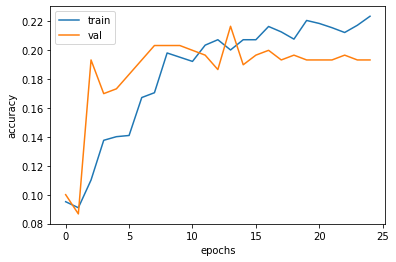

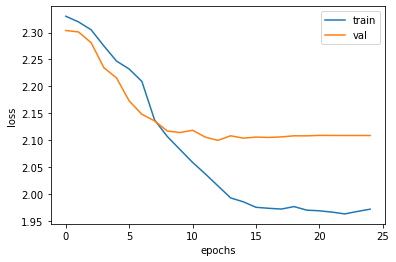

In [ ]:
def plot_performance(metric, values):
  plt.plot(values['train'])
  plt.plot(values['val'])
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend(values.keys())
  plt.show()

plot_performance('accuracy', accuracies)
plot_performance('loss', losses)

In [ ]:
# def test_model(model, criterion):

#     model.eval()   # Set model to evaluate mode

#     t_output = []
#     t_pred = []
#     y_test = []
#     top_k = []
#     # Iterate over data.
#     i = 1
#     for inputs, labels in dataloaders['test']:

#         # forward
#         # track history if only in train
#         with torch.no_grad():
            
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             y_test.append(labels)

#             outputs = model(inputs.float())
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)
#             t_output.append(outputs)
#             t_pred.append(preds)
#             temp1, temp2 = outputs.topk(5)
#             top_k.append(temp2)

#     y_test = torch.cat(y_test).cpu().detach().numpy() 
#     y_test_num = torch.cat(t_pred).cpu().detach().numpy() 
#     y_pred = torch.cat(top_k).cpu().detach().numpy() 

#     print('\nConfusion Matrix')
#     conf_mt = confusion_matrix(y_test_num, y_test)
#     print(conf_mt)
#     plt.matshow(conf_mt)
#     plt.show()
#     print('\nClassification Report')
#     print(classification_report(y_test_num, y_test, zero_division=0))

In [ ]:
def test_rnn_model(model, criterion, seq_length, input_size):

    model.eval()   # Set model to evaluate mode

    t_output = []
    t_pred = []
    y_test = []
    top_k = []
    # Iterate over data.
    i = 1
    for inputs, labels in dataloaders['test']:

        # forward
        # track history if only in train
        with torch.no_grad():

            # Reshape inputs to (batch_size, seq_length, input_size)
            new_inputs = inputs.reshape(-1, seq_length, input_size).to(device)
            labels = labels.to(device)
            y_test.append(labels)

            outputs = model(new_inputs.float(), False)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            t_output.append(outputs)
            t_pred.append(preds)
            temp1, temp2 = outputs.topk(5)
            top_k.append(temp2)

    y_test = torch.cat(y_test).cpu().detach().numpy() 
    y_test_num = torch.cat(t_pred).cpu().detach().numpy() 
    y_pred = torch.cat(top_k).cpu().detach().numpy() 

    print('\nConfusion Matrix')
    conf_mt = confusion_matrix(y_test_num, y_test)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, y_test, zero_division=0))

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
# model.load_state_dict(torch.load("GRUweights5.pth"))

<All keys matched successfully>


Confusion Matrix
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 5 22 27  4  5 22 19  8  2 25]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  1  3  0  1  0  0  0]
 [ 1  0  0  0  0  0  1  0  0  1]
 [ 2  1  2  1  4  0  0  1  3  1]
 [ 0  0  0  2  1  1  2  2  0  0]
 [21  7  1 22 17  7  7 19 25  3]
 [ 0  0  0  0  0  0  0  0  0  0]]


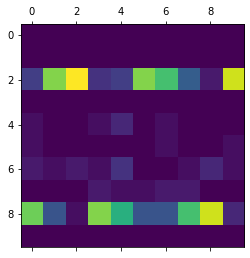


Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.90      0.19      0.32       139
           3       0.00      0.00      0.00         0
           4       0.10      0.50      0.17         6
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00        15
           7       0.07      0.25      0.11         8
           8       0.83      0.19      0.31       129
           9       0.00      0.00      0.00         0

    accuracy                           0.19       300
   macro avg       0.19      0.11      0.09       300
weighted avg       0.78      0.19      0.29       300



In [ ]:
test_rnn_model(model, criterion, seq_length, input_size)

In [ ]:
print(torch.__version__)

1.10.0+cu111
